# NMF Analysis

Performs a simple tf-idf of the question pairs and NMF dimension reduction to calculate cosine similarity of each question pair. The goal of the analysis is to see if the pairs labeled as duplicates have a distinctly different cosine similarity compared to those pairs marked as not duplicates.

In [1]:
# data manipulation
from utils import save, load
import pandas as pd
import numpy as np

# modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.metrics.pairwise import cosine_similarity

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# You can configure the format of the images: ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’.
%config InlineBackend.figure_format = 'svg'
# this statement allows the visuals to render within your Jupyter Notebook
%matplotlib inline

In [2]:
X_train = load('X_train')
y_train = load('y_train')
train_df = pd.DataFrame(np.concatenate([X_train, y_train.reshape(-1, 1)], axis=1))
train_df = train_df.rename(columns={0:'id', 1:'question1', 2:'question2', 3:'is_duplicate'})
train_df.head()

,id,question1,question2,is_duplicate
0,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


Let's make a stack of questions maintaining the `id` of the question pair.

In [3]:
question_df = train_df.loc[:, ['id', 'question1']]
question_df = question_df.append(train_df.loc[:,['id', 'question2']], sort=False)
question_df.loc[question_df['question1'].isna(), 'question1'] = question_df.loc[question_df['question1'].isna(), 'question2']
question_df = question_df.drop(columns='question2')
question_df = question_df.sort_values('id')
question_df.head(6)

,id,question1
0,0,What is the step by step guide to invest in sh...
0,0,What is the step by step guide to invest in sh...
1,1,What would happen if the Indian government sto...
1,1,What is the story of Kohinoor (Koh-i-Noor) Dia...
2,2,How can I increase the speed of my internet co...
2,2,How can Internet speed be increased by hacking...


Let's now calcualte the tf-idf term matrix.

In [4]:
tf = TfidfVectorizer(stop_words='english', token_pattern='\\b[a-zA-Z0-9][a-zA-Z0-9]+\\b')

question_tf = tf.fit_transform(question_df['question1'])

In [5]:
# first 10 terms
tf.get_feature_names()[:10]

['00',
 '000',
 '0000',
 '000000',
 '00000000',
 '0000000000',
 '0000001',
 '00000074',
 '0000021210',
 '00001']

In [6]:
# last 10 terms
tf.get_feature_names()[-10:]

['zygote',
 'zygotene',
 'zyl',
 'zylber',
 'zynga',
 'zyrtec',
 'zyzz',
 'zz',
 'zzz',
 'zzzquil']

In [7]:
# total terms
len(tf.get_feature_names())

74795

Lots of words, but some cleanup will probably needed given the numbers.

Let's now reduce the 74,795 term matrix utilizing NMF.

In [8]:
def calc_NMF_sim(n_components, col_name, tf_df, df):
    nmf = NMF(n_components=n_components)

    nmf_topics = nmf.fit_transform(tf_df)

    odd_idx = [i for i in range(nmf_topics.shape[0]) if i % 2 == 1]
    even_idx = [i for i in range(nmf_topics.shape[0]) if i % 2 == 0]

    sim_list = [cosine_similarity(
                                    nmf_topics[odd_idx[i]].reshape(1,-1),
                                    nmf_topics[even_idx[i]].reshape(1,-1)
                )[0,0]
                for i in range(len(odd_idx))]

    df = pd.concat([df.sort_values('id'), pd.Series(sim_list)], axis=1)
    df = df.rename(columns={0:col_name})
    
    return df

In [9]:
train_df_cosine = calc_NMF_sim(5, 'cos_sim_5', question_tf, train_df.reset_index())
train_df_cosine = calc_NMF_sim(10, 'cos_sim_10', question_tf, train_df_cosine)
train_df_cosine = calc_NMF_sim(50, 'cos_sim_50', question_tf, train_df_cosine)
train_df_cosine = calc_NMF_sim(100, 'cos_sim_100', question_tf, train_df_cosine)

In [10]:
train_df_cosine.head()

,index,id,question1,question2,is_duplicate,cos_sim_5,cos_sim_10,cos_sim_50,cos_sim_100
0,0,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,0.633264,0.671246,0.214359,0.333102
1,1,1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,0.862924,0.297672,0.024921,0.039276
2,2,2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,0.939746,0.691180,0.523763,0.441854
3,3,3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,0.844232,0.461991,0.469578,0.940291
4,4,4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,0.993024,0.982065,0.960928,0.893077


We calcualted the cosine similarity for 5, 10, 50, and 100 dimensional dimensional NMF. Let's now plot the distribution for the duplicate pairs and not duplicate pairs. The goal is to see if there is a natural division based purely on the cosine similarity between the pair of questions.

## This seems off!!!

Need to figure out why there is so much overlap now. Let's ignore for now and see if the MVP model suffers the same.

''

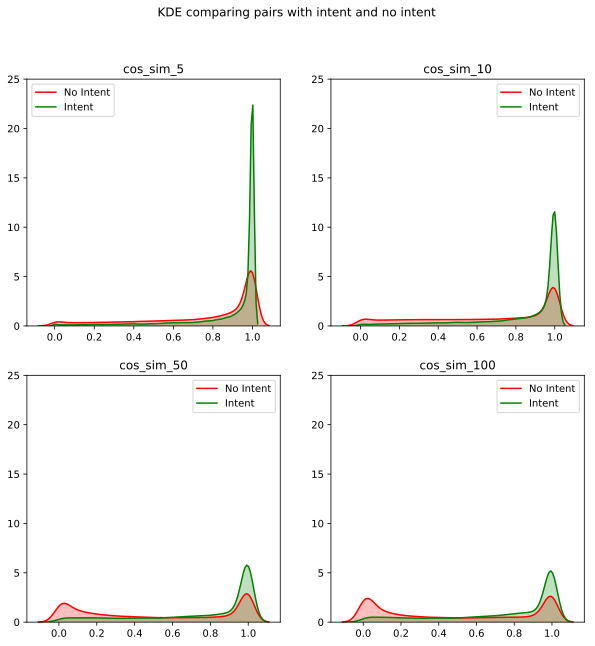

In [13]:
cols = ['cos_sim_5', 'cos_sim_10', 'cos_sim_50', 'cos_sim_100']
plt.figure(figsize=(10,10))

for i in range(4):
    plt.subplot(2, 2, i+1)
    sns.kdeplot(train_df_cosine.loc[train_df_cosine['is_duplicate'] == 0, cols[i]], 
                 shade=True, 
                 label = 'No Intent',
                 color = 'red')
    sns.kdeplot(train_df_cosine.loc[train_df_cosine['is_duplicate'] == 1, cols[i]], 
                 shade=True,
                 label = 'Intent',
                 color = 'green')
    plt.title(cols[i])
    plt.ylim(top=25)

# plt.xlabel('cosine similarity')
# plt.ylabel('density')
plt.suptitle('KDE comparing pairs with intent and no intent')
;

More of the duplicate pairs have a higher cosine similarity compared to the non-duplicate pairs. However, there is also significant overlap, which means finding the decision boundary will be difficult.

Let's take a look at the set of pairs marked as duplicates with a 0 cosine similarity with the NMF 100 transformation.

In [12]:
train_df_cosine[(train_df_cosine['is_duplicate'] == 1) & (train_df_cosine['cos_sim_100'] == 0)]

,index,id,question1,question2,is_duplicate,cos_sim_5,cos_sim_10,cos_sim_50,cos_sim_100
2672,2672,3526,What does agape mean?,What is agape (love)?,1,0.394222,0.074720,0.000000,0.0
4353,4353,5745,How does a precision rectifier work?,Why we use precision rectifier?,1,0.366223,0.339545,0.000000,0.0
7162,7162,9574,What is human body made up of?,What are you made of?,1,0.000000,0.000000,0.000000,0.0
8493,8493,11337,What does Netlogon do?,What is NetLogon used for?,1,0.559942,0.251427,0.010065,0.0
9324,9324,12463,How do I find out if I have a warrent?,How do I find out about a warrent?,1,0.000000,0.000000,0.000000,0.0
9497,9497,12706,How do you get a girl to like you?,What are some ways to get a girlfriend?,1,0.062028,0.113867,0.037448,0.0
12535,12535,16857,How can you learn Hadoop?,What is essential to start learning Hadoop?,1,0.825164,0.984763,0.000073,0.0
14763,14763,19874,Why the language C++ is named so? Why was it n...,Why C++ and not ++C?,1,0.000000,0.000000,0.000000,0.0
17462,17462,23456,How do you know if you have a cavity?,How can you tell if you have a tooth cavity?,1,0.673022,0.304215,0.000000,0.0
20600,20600,27647,How was the 90s different from now?,What is the difference between life in the 90s...,1,0.828017,0.060438,0.218934,0.0


The first example is very confusing. This may be a result of the tf-idf calculation with default parameters is incorrect, or the cosine similarity is not the best metric. The next step would be to build a classification model using NMF or LDA topics for the pair of questions to predict whether or not the pair has the same intent.